In [1]:
########################################
# 1. SETUP & CONFIGURATION
########################################

# --- Hugging Face Login ---
from google.colab import userdata
from huggingface_hub import notebook_login

hf_token = userdata.get('HF_TOKEN')
if not hf_token:
    raise ValueError("HF_TOKEN not found in Colab Secrets. Please complete the prerequisite steps.")
notebook_login(new_session=hf_token)

!pip install -U transformers==4.53.2
!pip install -U peft
!pip install -U trl
!pip install -U accelerate
!pip install -U datasets
!pip install -U bitsandbytes
!pip install vllm==0.7.3
!pip install torch==2.6.0 torchvision --index-url https://download.pytorch.org/whl/test/cu124

# Install Flash Attention 2
!pip install flash-attn==2.7.4.post1 \
  --extra-index-url https://download.pytorch.org/whl/cu124 \
  --no-build-isolation


  Using cached torch-2.5.1-cp311-cp311-manylinux1_x86_64.whl.metadata (28 kB)
  Using cached torchvision-0.20.1-cp311-cp311-manylinux1_x86_64.whl.metadata (6.1 kB)
  Using cached triton-3.1.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.3 kB)
Using cached torch-2.5.1-cp311-cp311-manylinux1_x86_64.whl (906.5 MB)
Using cached torchvision-0.20.1-cp311-cp311-manylinux1_x86_64.whl (7.2 MB)
Using cached triton-3.1.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (209.5 MB)
  Attempting uninstall: triton
    Found existing installation: triton 3.2.0
    Uninstalling triton-3.2.0:
      Successfully uninstalled triton-3.2.0
  Attempting uninstall: torch
    Found existing installation: torch 2.6.0+cu124
    Uninstalling torch-2.6.0+cu124:
      Successfully uninstalled torch-2.6.0+cu124
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.21.0+cu124
    Uninstalling torchvision-0.21.0+cu124:
      Successfully uninstalled torc

In [2]:
# --- Experiment Configuration ---
from pathlib import Path
import json
import datetime
import torch
import random
import numpy as np

CONFIG = {
    # Core experiment parameters
    "experiment_type": "generative",
    "classification_type": "ternary",
    "dataset_strategy": "4N",
    "include_explanation": True,
    "include_eln": True,
    "solution_format": "nl",
    "model_name": "microsoft/phi-4-mini-instruct",

    # Prompting configuration
    "include_examples": True,
    "num_examples": 1,
    "example_strategy": "balanced",

    # Training parameters
    "learning_rate": 2e-4,
    "num_epochs": 3,
    "batch_size": 8,
    "inference_batch_size": 32, # Adjusted for few-shot prompt length
    "max_length": 2048, # Increased to accommodate few-shot examples
    "gradient_accumulation_steps": 4,

    # LoRa params
    "lora_rank": 16,
    "lora_alpha": 32,
    "lora_dropout": 0.1,

    # Paths and tokens
    "base_dataset_dir": "/content",
    "output_base_dir": "/content",

    # Experiment tracking
    "save_to_hf": True,
    "save_locally": True,
}

# --- Generate Unique Experiment ID ---
experiment_components = [
    CONFIG["experiment_type"][:4],
    CONFIG["classification_type"][:3],
    CONFIG["dataset_strategy"],
    "exp" if CONFIG["include_explanation"] else "no_exp",
    "eln" if CONFIG["include_eln"] else "no_eln",
    CONFIG["solution_format"],
    "phi4" if "phi" in CONFIG["model_name"].lower() else "qwen"
]
experiment_id = "_".join([c for c in experiment_components if c]) + "_" + datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
CONFIG["experiment_id"] = experiment_id
print(f"Experiment ID: {experiment_id}")

# --- Setup Output Directories ---
def setup_output_directory():
    output_dir = Path(CONFIG["output_base_dir"]) / CONFIG["experiment_id"]
    # Create the directory structure from the screenshot
    (output_dir / "baseline").mkdir(parents=True, exist_ok=True)
    (output_dir / "training").mkdir(parents=True, exist_ok=True)
    (output_dir / "final").mkdir(parents=True, exist_ok=True)

    config_path = output_dir / "config.json"
    with open(config_path, 'w') as f:
        json.dump(CONFIG, f, indent=2, default=str)
    print(f"Output directory created: {output_dir}")
    return output_dir

CONFIG["output_dir"] = setup_output_directory()

# --- Set Random Seeds for Reproducibility ---
def set_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

set_seeds(42)
print("✅ Setup complete. Dependencies installed and seeds set.")

Experiment ID: gene_ter_4N_exp_eln_nl_phi4_20250803_192535
Output directory created: /content/gene_ter_4N_exp_eln_nl_phi4_20250803_192535
✅ Setup complete. Dependencies installed and seeds set.


In [3]:
########################################
# 2. CORE FUNCTION DEFINITIONS
########################################

import pandas as pd
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, GenerationConfig
from peft import LoraConfig, get_peft_model, TaskType, prepare_model_for_kbit_training

def get_system_prompt():
    """Generates the specific system prompt for the fine-tuning task."""
    return """You are a mathematics tutor.
You are given a math word problem, and a solution written by a student.
Analyze the solution carefully, line-by-line, and classify it into one of the following categories:
- Correct (All logic is correct, and all calculations are correct)
- Conceptual Error (There is an error in reasoning or logic somewhere in the solution)
- Computational Error (All logic and reasoning is correct, but the result of some calculation is incorrect)
Respond *only* with a valid JSON object that follows this exact schema:
```json
{
  "verdict": "must be one of 'correct', 'conceptual_error', or 'computational_error'",
  "erroneous_line": "the exact, verbatim text of the first incorrect line, or null if the verdict is 'correct'",
  "explanation": "a brief, one-sentence explanation of the error, or null if the verdict is 'correct'"
}
```
Do NOT add any text or explanations before or after the JSON object.
"""

def load_base_dataset():
    """Loads the base dataset from the specified CSV file."""
    base_dir = Path(CONFIG["base_dataset_dir"])
    dataset_file = base_dir / f"base_{CONFIG['dataset_strategy']}_dataset_sanitized.csv"
    data = pd.read_csv(dataset_file)
    print(f"Loaded base {CONFIG['dataset_strategy']} dataset with {len(data)} samples")
    return data

def load_model():
    """Loads the quantized model."""
    model_name = CONFIG["model_name"]
    print(f"Loading model: {model_name}")
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.float16,
        bnb_4bit_use_double_quant=True
    )
    lora_config = LoraConfig(
        task_type=TaskType.CAUSAL_LM,
        r=CONFIG["lora_rank"],
        lora_alpha=CONFIG["lora_alpha"],
        lora_dropout=CONFIG["lora_dropout"],
        target_modules="all-linear",
        bias="none"
    )
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        quantization_config=bnb_config,
        device_map="auto",
        trust_remote_code=True,
        attn_implementation="flash_attention_2"
    )
    model = prepare_model_for_kbit_training(model)
    model = get_peft_model(model, lora_config)

    model.generation_config = GenerationConfig(
        max_new_tokens=128,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.pad_token_id,
        do_sample=False
    )

    return model

def load_tokenizer():
    """Loads the tokenizer."""
    model_name = CONFIG["model_name"]
    print(f"Loading tokenizer: {model_name}")
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    tokenizer.padding_side = "left"
    return tokenizer

def load_model_and_tokenizer():
    """Loads the quantized model and tokenizer with LoRA configuration."""
    model_name = CONFIG["model_name"]
    print(f"Loading tokenizer: {model_name}")
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    tokenizer.padding_side = "left"

    print(f"Loading model: {model_name}")
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.float16,
        bnb_4bit_use_double_quant=True
    )
    lora_config = LoraConfig(
        task_type=TaskType.CAUSAL_LM,
        r=CONFIG["lora_rank"],
        lora_alpha=CONFIG["lora_alpha"],
        lora_dropout=CONFIG["lora_dropout"],
        target_modules="all-linear",
        bias="none"
    )
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        quantization_config=bnb_config,
        device_map="auto",
        trust_remote_code=True,
        attn_implementation="flash_attention_2"
    )
    model = prepare_model_for_kbit_training(model)
    model = get_peft_model(model, lora_config)

    model.generation_config = GenerationConfig(
        max_new_tokens=128,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.pad_token_id,
        do_sample=False
    )
    print("✅ Model and tokenizer loaded")
    model.print_trainable_parameters()
    return model, tokenizer

In [9]:
##################################################
# 3. DATA PREPARATION (WITH FEW-SHOT EXAMPLES)
##################################################

from datasets import Dataset
import math

class ExampleManager:
    def __init__(self, base_dataset):
        self.samples = base_dataset.to_dict('records')
        self.config = CONFIG
        self._prepare_examples_by_problem()

    def _prepare_examples_by_problem(self):
        self.problems_by_type = {"correct": {}, "conceptual_error": {}, "computational_error": {}}
        for sample in self.samples:
            problem_index = sample["index"]
            error_type = sample["error_type"]
            if problem_index not in self.problems_by_type[error_type]:
                self.problems_by_type[error_type][problem_index] = []
            self.problems_by_type[error_type][problem_index].append(sample)

    def get_examples(self):
        """Returns examples based on dataset strategy"""
        if not self.config["include_examples"]:
            return []
        num_examples = self.config["num_examples"]
        dataset_strategy = self.config["dataset_strategy"]
        examples = []

        import random
        if dataset_strategy == "3N":
            # Choose num_examples distinct problem indices that have all 3 versions
            available_problems = set(self.problems_by_type["correct"].keys()) & \
                               set(self.problems_by_type["conceptual_error"].keys()) & \
                               set(self.problems_by_type["computational_error"].keys())
            # Sample problem indices
            selected_problems = random.sample(list(available_problems), num_examples)
            for problem_index in selected_problems:
                # Add all 3 versions: correct, conceptual_error, computational_error
                examples.append(self.problems_by_type["correct"][problem_index][0])
                examples.append(self.problems_by_type["conceptual_error"][problem_index][0])
                examples.append(self.problems_by_type["computational_error"][problem_index][0])

            return examples

        elif dataset_strategy == "4N":
            import math
            # Get problems that have conceptual errors (with correct versions)
            conceptual_problems = list(
                set(self.problems_by_type["correct"].keys()) &
                set(self.problems_by_type["conceptual_error"].keys())
            )
            # Get problems that have computational errors (with correct versions)
            computational_problems = list(
                set(self.problems_by_type["correct"].keys()) &
                set(self.problems_by_type["computational_error"].keys())
            )
            # Calculate splits: floor(n/2) conceptual, ceil(n/2) computational
            n_conceptual = num_examples // 2  # This is floor(n/2)
            n_computational = math.ceil(num_examples / 2)

            # Sample conceptual problems
            if conceptual_problems and n_conceptual > 0:
                selected_conceptual = random.sample(conceptual_problems,n_conceptual)
                for problem_index in selected_conceptual:
                    # Add correct + conceptual_error pair
                    examples.append(self.problems_by_type["correct"][problem_index][0])
                    examples.append(self.problems_by_type["conceptual_error"][problem_index][0])

            # Sample computational problems
            if computational_problems and n_computational > 0:
                selected_computational = random.sample(computational_problems,n_computational)
                for problem_index in selected_computational:
                    # Add correct + computational_error pair
                    examples.append(self.problems_by_type["correct"][problem_index][0])
                    examples.append(self.problems_by_type["computational_error"][problem_index][0])

            return examples

        else:
            print(f"Warning: Unknown dataset strategy '{dataset_strategy}'")
            return []

def format_user_message(sample):
    """Formats a sample into a user message string."""
    question = sample.get('question', '') or ''
    solution = sample.get('correct_answer' if sample['error_type'] == 'correct' else 'wrong_answer', '').strip()
    return f"### Question:\n{question}\n\n### Answer:\n{solution}"

def format_expected_output(sample):
    """Creates the expected JSON string for a sample."""
    output = {"verdict": sample["error_type"], "explanation": sample.get("explanation")}
    if sample["error_type"] == "correct":
        output["erroneous_line"] = None
    else:
        solution_text = sample.get("wrong_answer", "").strip()
        lines = solution_text.strip().split('\n')
        mapping = {f"L{i+1}": line.strip() for i, line in enumerate(lines[:-1]) if line.strip()}
        mapping["FA"] = lines[-1].strip()
        output["erroneous_line"] = mapping.get(sample["erroneous_line_number"])
    return json.dumps(output)

def create_sample_messages(sample, examples):
    """Creates the full message list for a sample, including few-shot examples."""
    messages = [{"role": "system", "content": get_system_prompt()}]
    for example in examples:
        messages.append({"role": "user", "content": format_user_message(example)})
        messages.append({"role": "assistant", "content": format_expected_output(example)})
    messages.append({"role": "user", "content": format_user_message(sample)})
    return messages

def prepare_data_for_run(tokenizer, base_df):
    """Prepares data, generates examples, and returns datasets."""
    test_df = base_df.sample(frac=0.2, random_state=42)
    train_df = base_df.drop(test_df.index)
    print(f"Data split: {len(train_df)} training samples, {len(test_df)} test samples.")

    example_manager = ExampleManager(base_df)
    examples = example_manager.get_examples()
    print(f"Generated {len(examples)} few-shot examples for this run.")

    def create_training_text(sample):
        # Re-use the message creation logic, now including examples
        messages = create_sample_messages(sample, examples)
        # Add the final assistant response for the training label
        messages.append({"role": "assistant", "content": format_expected_output(sample)})
        return {"text": tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=False)}

    train_dataset = Dataset.from_pandas(train_df)
    train_dataset_formatted = train_dataset.map(create_training_text, load_from_cache_file=False)
    train_dataset_tokenized = train_dataset_formatted.map(
        lambda x: tokenizer(
            x["text"],
            truncation=True,
            max_length=CONFIG["max_length"],
            padding=False),
        remove_columns=['text'] + list(train_df.columns)
    )
    return train_dataset_tokenized, test_df, examples

print("✅ Data preparation functions (with ExampleManager) loaded.")

✅ Data preparation functions (with ExampleManager) loaded.


In [5]:
########################################
# 4. INFERENCE & EVALUATION FUNCTIONS
########################################

from vllm import LLM, SamplingParams
import math
import re
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def run_vllm_inference_on_dataframe(model_name_or_path, tokenizer, df, examples):
    """Runs highly optimized inference using the vLLM engine."""
    print(f"\n--- Initializing vLLM engine for model: {model_name_or_path} ---")

    llm = LLM(
        model=model_name_or_path,
        trust_remote_code=True,
        max_model_len=4096,
        gpu_memory_utilization=0.90
    )

    sampling_params = SamplingParams(temperature=0, max_tokens=128)

    print("--- Preparing prompts for vLLM ---")
    all_prompts = []
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Formatting Prompts"):
        messages = create_sample_messages(row.to_dict(), examples)
        prompt_string = tokenizer.apply_chat_template(
            messages, tokenize=False, add_generation_prompt=True
        )
        all_prompts.append(prompt_string)

    print(f"\n--- Running vLLM inference on {len(all_prompts)} prompts ---")
    vllm_outputs = llm.generate(all_prompts, sampling_params)

    predictions = [output.outputs[0].text for output in vllm_outputs]
    print("--- vLLM Inference complete ---")
    return predictions

def extract_json_from_response(response):
    """Extracts a JSON object from a model's text response."""
    match = re.search(r'\{.*\}', response, re.DOTALL)
    return json.loads(match.group(0)) if match else {}

def create_detailed_results(test_df, predictions):
    """Merges model predictions with original test data."""
    results = []
    for i, pred_text in enumerate(predictions):
        original_sample = test_df.iloc[i].to_dict()
        parsed_json = extract_json_from_response(pred_text)
        expected_json = json.loads(format_expected_output(original_sample))
        result_row = {
            'problem_index': original_sample.get('index'),
            'expected_verdict': original_sample.get('error_type'),
            'predicted_verdict': parsed_json.get('verdict'),
            'verdict_correct': original_sample.get('error_type') == parsed_json.get('verdict'),
            'expected_erroneous_line': expected_json.get('erroneous_line'),
            'predicted_erroneous_line': parsed_json.get('erroneous_line'),
            'full_prediction_text': pred_text.strip(),
        }
        results.append(result_row)
    return pd.DataFrame(results)

def normalize_text(text):
    """Normalizes text by removing all whitespace and converting to lowercase."""
    return re.sub(r'\s+', '', str(text).lower().strip()) if text else ""

def compute_metrics_from_results(results_df):
    """Calculates verdict and erroneous line accuracy from the results DataFrame."""
    y_true_verdict = results_df['expected_verdict']
    y_pred_verdict = results_df['predicted_verdict'].fillna('parse_failure')
    accuracy = accuracy_score(y_true_verdict, y_pred_verdict)
    labels = list(y_true_verdict.unique()) + ['parse_failure']
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true_verdict,
        y_pred_verdict,
        average='macro',
        zero_division=0,
        labels=labels)

    error_rows = results_df[results_df['expected_verdict'].isin(['conceptual_error', 'computational_error'])].copy()
    eln_accuracy = accuracy_score(
        error_rows['expected_erroneous_line'].apply(normalize_text),
        error_rows['predicted_erroneous_line'].apply(normalize_text)
        ) if not error_rows.empty else 1.0

    return {
        "overall_accuracy": accuracy,
        "precision_macro": precision,
        "recall_macro": recall,
        "f1_macro": f1,
        "eln_accuracy_on_errors": eln_accuracy,
        "total_samples": len(results_df),
        "error_samples_for_eln": len(error_rows),
        "parse_failures": int(results_df['predicted_verdict'].isnull().sum())
    }

print("✅ Inference and evaluation functions loaded.")

✅ Inference and evaluation functions loaded.


In [6]:
########################################
# 5. FINE-TUNING LOOP
########################################

from transformers import Trainer, TrainingArguments, DataCollatorForLanguageModeling

def run_fine_tuning(model, tokenizer, train_dataset):
    """
    Runs a focused fine-tuning process without intermediate evaluation.
    """
    output_dir = CONFIG["output_dir"]

    training_args = TrainingArguments(
        output_dir=str(output_dir / "training_run"),
        num_train_epochs=CONFIG["num_epochs"],
        per_device_train_batch_size=CONFIG["batch_size"],
        gradient_accumulation_steps=CONFIG["gradient_accumulation_steps"],
        optim="paged_adamw_8bit",
        learning_rate=CONFIG["learning_rate"],
        lr_scheduler_type="cosine",
        warmup_ratio=0.1,
        bf16=True,
        logging_steps=10,
        report_to="none",
        eval_strategy="no",
        save_strategy="epoch", # Save adapter at the end of each epoch
        save_total_limit=1, # Only keep the best/last checkpoint
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        processing_class=tokenizer,
        data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False)
    )

    print(f"\n--- Starting fine-tuning for {CONFIG['num_epochs']} epochs ---")
    trainer.train()

    # Save the final adapter to a dedicated directory
    final_adapter_dir = output_dir / "final_adapter"
    trainer.save_model(str(final_adapter_dir))
    print(f"\n✅✅✅ Fine-tuning finished! Final adapter saved to {final_adapter_dir} ✅✅✅")

print("✅ Fine-tuning function loaded.")

✅ Fine-tuning function loaded.


In [10]:
# ########################################
# # PIPELINE STEP 1: INITIALIZATION
# ########################################

tokenizer = load_tokenizer()
base_df = load_base_dataset()
train_dataset, test_df, examples = prepare_data_for_run(tokenizer, base_df)

Loading tokenizer: microsoft/phi-4-mini-instruct
Loaded base 4N dataset with 7524 samples
Data split: 6019 training samples, 1505 test samples.
Generated 2 few-shot examples for this run.


Map:   0%|          | 0/6019 [00:00<?, ? examples/s]

Map:   0%|          | 0/6019 [00:00<?, ? examples/s]

In [11]:
##########
# VIEW A SAMPLE PROMPT
##########

print("--- Displaying a complete sample prompt for verification ---\n")

# Make sure the necessary variables are available from previous cells
if 'test_df' not in locals() or 'examples' not in locals() or 'tokenizer' not in locals():
    print("Please run the 'PIPELINE STEP 1: INITIALIZATION' cell first to load data.")
else:
    # Select the first sample from the test set to use for this example
    sample_to_view = test_df.iloc[0].to_dict()
    print(f"--- Using Sample from Problem Index: {sample_to_view.get('index')} ---")
    print(f"--- Expected Verdict: {sample_to_view.get('error_type')} ---\n")

    # Use the existing helper function to construct the full message list,
    # including the system prompt and the few-shot examples.
    sample_messages = create_sample_messages(sample_to_view, examples)

    # Use the tokenizer's chat template to render the final string.
    # - tokenize=False returns the formatted string.
    # - add_generation_prompt=True adds the final special tokens that signal
    #   to the model that it is its turn to generate a response.
    final_prompt_string = tokenizer.apply_chat_template(
        sample_messages,
        tokenize=False,
        add_generation_prompt=True
    )

    # Print the final, complete prompt
    print("--- FULL PROMPT AS SEEN BY THE MODEL ---")
    print(final_prompt_string)

--- Displaying a complete sample prompt for verification ---

--- Using Sample from Problem Index: 5515 ---
--- Expected Verdict: conceptual_error ---

--- FULL PROMPT AS SEEN BY THE MODEL ---
<|system|>You are a mathematics tutor. 
You are given a math word problem, and a solution written by a student. 
Analyze the solution carefully, line-by-line, and classify it into one of the following categories:
- Correct (All logic is correct, and all calculations are correct)
- Conceptual Error (There is an error in reasoning or logic somewhere in the solution)
- Computational Error (All logic and reasoning is correct, but the result of some calculation is incorrect)
Respond *only* with a valid JSON object that follows this exact schema:
```json
{
  "verdict": "must be one of 'correct', 'conceptual_error', or 'computational_error'",
  "erroneous_line": "the exact, verbatim text of the first incorrect line, or null if the verdict is 'correct'",
  "explanation": "a brief, one-sentence explanatio

In [12]:
##########
# PIPELINE STEP 2: BASELINE EVALUATION (with vLLM)
##########

import gc

baseline_predictions = run_vllm_inference_on_dataframe(CONFIG["model_name"], tokenizer, test_df, examples)
baseline_results_df = create_detailed_results(test_df, baseline_predictions)
baseline_metrics = compute_metrics_from_results(baseline_results_df)

print("\n--- Baseline Metrics ---")
print(json.dumps(baseline_metrics, indent=2))

# Save results
baseline_dir = CONFIG["output_dir"] / "baseline"
baseline_results_df.to_csv(baseline_dir / "results_baseline.csv", index=False)
with open(baseline_dir / "metrics_baseline.json", 'w') as f:
    json.dump(baseline_metrics, f, indent=2)
print(f"Baseline results saved to {baseline_dir}")

# --- CRUCIAL: Release vLLM resources ---
# We must delete the llm object created inside the function, which is now out of scope.
# Triggering garbage collection and emptying the cache ensures the GPU is free.
print("\nReleasing vLLM engine from GPU memory...")
gc.collect()
torch.cuda.empty_cache()
print("✅ GPU memory cleared.")


--- Initializing vLLM engine for model: microsoft/phi-4-mini-instruct ---
INFO 08-03 19:32:38 __init__.py:207] Automatically detected platform cuda.
INFO 08-03 19:32:38 config.py:208] Replacing legacy 'type' key with 'rope_type'
INFO 08-03 19:32:51 config.py:549] This model supports multiple tasks: {'generate', 'embed', 'score', 'reward', 'classify'}. Defaulting to 'generate'.
INFO 08-03 19:32:51 llm_engine.py:234] Initializing a V0 LLM engine (v0.7.3) with config: model='microsoft/phi-4-mini-instruct', speculative_config=None, tokenizer='microsoft/phi-4-mini-instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=True, dtype=torch.bfloat16, max_seq_len=4096, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto,  device_config=cuda, decoding_config=DecodingConf

Loading safetensors checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]


INFO 08-03 19:32:57 model_runner.py:1115] Loading model weights took 7.1694 GB
INFO 08-03 19:32:58 worker.py:267] Memory profiling takes 0.92 seconds
INFO 08-03 19:32:58 worker.py:267] the current vLLM instance can use total_gpu_memory (39.56GiB) x gpu_memory_utilization (0.90) = 35.60GiB
INFO 08-03 19:32:58 worker.py:267] model weights take 7.17GiB; non_torch_memory takes 0.09GiB; PyTorch activation peak memory takes 1.85GiB; the rest of the memory reserved for KV Cache is 26.50GiB.
INFO 08-03 19:32:59 executor_base.py:111] # cuda blocks: 13565, # CPU blocks: 2048
INFO 08-03 19:32:59 executor_base.py:116] Maximum concurrency for 4096 tokens per request: 52.99x
INFO 08-03 19:33:01 model_runner.py:1434] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI. If out-of-memory error occurs during cudagraph capture, consider decreasing `gpu_memory_ut

Capturing CUDA graph shapes: 100%|██████████| 35/35 [00:30<00:00,  1.14it/s]

INFO 08-03 19:33:31 model_runner.py:1562] Graph capturing finished in 31 secs, took 0.41 GiB
INFO 08-03 19:33:31 llm_engine.py:436] init engine (profile, create kv cache, warmup model) took 34.29 seconds
--- Preparing prompts for vLLM ---


Formatting Prompts:   0%|          | 0/1505 [00:00<?, ?it/s]


--- Running vLLM inference on 1505 prompts ---


Processed prompts:   0%|          | 0/1505 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

WARNING 08-03 19:33:43 scheduler.py:1754] Sequence group 251 is preempted by PreemptionMode.RECOMPUTE mode because there is not enough KV cache space. This can affect the end-to-end performance. Increase gpu_memory_utilization or tensor_parallel_size to provide more KV cache memory. total_num_cumulative_preemption=1


Processed prompts: 100%|██████████| 1505/1505 [01:10<00:00, 21.37it/s, est. speed input: 17980.62 toks/s, output: 909.53 toks/s]


--- vLLM Inference complete ---

--- Baseline Metrics ---
{
  "overall_accuracy": 0.5116279069767442,
  "precision_macro": 0.4691036359185825,
  "recall_macro": 0.294970417815812,
  "f1_macro": 0.2513835816344619,
  "eln_accuracy_on_errors": 0.19842312746386334,
  "total_samples": 1505,
  "error_samples_for_eln": 761,
  "parse_failures": 1
}
Baseline results saved to /content/gene_ter_4N_exp_eln_nl_phi4_20250803_192535/baseline

Releasing vLLM engine from GPU memory...
✅ GPU memory cleared.


In [13]:
##########
# PIPELINE STEP 3: RUN FINE-TUNING
##########

# Load a fresh model specifically for training
training_model = load_model()

run_fine_tuning(training_model, tokenizer, train_dataset)

# --- CRUCIAL: Release training resources ---
print("\nReleasing training model from GPU memory...")
del training_model
gc.collect()
torch.cuda.empty_cache()
print("✅ GPU memory cleared.")

Loading model: microsoft/phi-4-mini-instruct


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

torch.distributed process group is initialized, but parallel_mode != ParallelMode.DISTRIBUTED. In order to use Torch DDP, launch your script with `python -m torch.distributed.launch
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
The input hidden states seems to be silently casted in float32, this might be related t


--- Starting fine-tuning for 3 epochs ---


Step,Training Loss
10,1.298200
20,0.916900
30,0.496400
40,0.244000
50,0.186500
60,0.157300
70,0.149400
80,0.145600
90,0.139400
100,0.138100


/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)



✅✅✅ Fine-tuning finished! Final adapter saved to /content/gene_ter_4N_exp_eln_nl_phi4_20250803_192535/final_adapter ✅✅✅

Releasing training model from GPU memory...
✅ GPU memory cleared.


In [14]:
##########
# PIPELINE STEP 4: FINAL EVALUATION ON BEST MODEL (with vLLM)
##########
from peft import PeftModel

# --- Merge the adapter with the base model ---
print("\nMerging fine-tuned adapter with the base model...")
adapter_dir = CONFIG["output_dir"] / "final_adapter"
merged_model_dir = CONFIG["output_dir"] / "final_merged_model"

# Load base model on CPU to avoid using GPU memory during merge
base_model = AutoModelForCausalLM.from_pretrained(
    CONFIG["model_name"],
    torch_dtype=torch.float16,
    low_cpu_mem_usage=True,
    trust_remote_code=True,
)
model_with_adapter = PeftModel.from_pretrained(base_model, str(adapter_dir))
merged_model = model_with_adapter.merge_and_unload()
merged_model.save_pretrained(str(merged_model_dir))
tokenizer.save_pretrained(str(merged_model_dir))
print(f"Merged model saved to {merged_model_dir}")

# --- Clear memory before loading vLLM ---
del base_model, model_with_adapter, merged_model
gc.collect()
torch.cuda.empty_cache()

# --- Run Final Inference on Merged Model ---
final_predictions = run_vllm_inference_on_dataframe(str(merged_model_dir), tokenizer, test_df, examples)
final_results_df = create_detailed_results(test_df, final_predictions)
final_metrics = compute_metrics_from_results(final_results_df)

print("\n--- Final Metrics (Best Model) ---")
print(json.dumps(final_metrics, indent=2))

final_dir = CONFIG["output_dir"] / "final"
final_results_df.to_csv(final_dir / "results_final_best.csv", index=False)
with open(final_dir / "metrics_final_best.json", 'w') as f:
    json.dump(final_metrics, f, indent=2)
print(f"Final results saved to {final_dir}")


Merging fine-tuned adapter with the base model...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Merged model saved to /content/gene_ter_4N_exp_eln_nl_phi4_20250803_192535/final_merged_model

--- Initializing vLLM engine for model: /content/gene_ter_4N_exp_eln_nl_phi4_20250803_192535/final_merged_model ---
INFO 08-03 20:59:03 config.py:208] Replacing legacy 'type' key with 'rope_type'
INFO 08-03 20:59:03 config.py:549] This model supports multiple tasks: {'generate', 'embed', 'score', 'reward', 'classify'}. Defaulting to 'generate'.
INFO 08-03 20:59:03 llm_engine.py:234] Initializing a V0 LLM engine (v0.7.3) with config: model='/content/gene_ter_4N_exp_eln_nl_phi4_20250803_192535/final_merged_model', speculative_config=None, tokenizer='/content/gene_ter_4N_exp_eln_nl_phi4_20250803_192535/final_merged_model', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=True, dtype=torch.float16, max_seq_len=4096, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1,

Loading safetensors checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]


INFO 08-03 20:59:07 model_runner.py:1115] Loading model weights took 7.1694 GB
INFO 08-03 20:59:08 worker.py:267] Memory profiling takes 0.76 seconds
INFO 08-03 20:59:08 worker.py:267] the current vLLM instance can use total_gpu_memory (39.56GiB) x gpu_memory_utilization (0.90) = 35.60GiB
INFO 08-03 20:59:08 worker.py:267] model weights take 7.17GiB; non_torch_memory takes 0.01GiB; PyTorch activation peak memory takes 1.84GiB; the rest of the memory reserved for KV Cache is 26.59GiB.
INFO 08-03 20:59:09 executor_base.py:111] # cuda blocks: 13613, # CPU blocks: 2048
INFO 08-03 20:59:09 executor_base.py:116] Maximum concurrency for 4096 tokens per request: 53.18x
INFO 08-03 20:59:09 model_runner.py:1434] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI. If out-of-memory error occurs during cudagraph capture, consider decreasing `gpu_memory_ut

Capturing CUDA graph shapes: 100%|██████████| 35/35 [00:33<00:00,  1.03it/s]

INFO 08-03 20:59:43 model_runner.py:1562] Graph capturing finished in 34 secs, took 0.32 GiB
INFO 08-03 20:59:43 llm_engine.py:436] init engine (profile, create kv cache, warmup model) took 35.64 seconds
--- Preparing prompts for vLLM ---


Formatting Prompts:   0%|          | 0/1505 [00:00<?, ?it/s]


--- Running vLLM inference on 1505 prompts ---


Processed prompts:   0%|          | 0/1505 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

WARNING 08-03 20:59:56 scheduler.py:1754] Sequence group 252 is preempted by PreemptionMode.RECOMPUTE mode because there is not enough KV cache space. This can affect the end-to-end performance. Increase gpu_memory_utilization or tensor_parallel_size to provide more KV cache memory. total_num_cumulative_preemption=1


Processed prompts: 100%|██████████| 1505/1505 [01:16<00:00, 19.61it/s, est. speed input: 16504.73 toks/s, output: 932.07 toks/s]


--- vLLM Inference complete ---

--- Final Metrics (Best Model) ---
{
  "overall_accuracy": 0.7029900332225913,
  "precision_macro": 0.5217571555477325,
  "recall_macro": 0.5114171649081716,
  "f1_macro": 0.5150649031674572,
  "eln_accuracy_on_errors": 0.5440210249671484,
  "total_samples": 1505,
  "error_samples_for_eln": 761,
  "parse_failures": 6
}
Final results saved to /content/gene_ter_4N_exp_eln_nl_phi4_20250803_192535/final


In [15]:
##########
# PIPELINE STEP 6: COMPRESS RESULTS FOR DOWNLOAD
##########

import zipfile
from pathlib import Path

print("Compressing experiment results...")

# Define the root directory of your experiment
root_dir = Path(CONFIG["output_dir"])
zip_path = root_dir / f"{CONFIG['experiment_id']}_results.zip"

# Define the folder to exclude
exclude_dir = root_dir / "final_merged_model"

with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    # Walk through all the files and folders in the root directory
    for file_path in root_dir.rglob('*'):
        # Check if the current file_path is inside the excluded directory
        if exclude_dir in file_path.parents or file_path == exclude_dir:
            continue # Skip this file or folder

        # Check if the path is the zip file itself to avoid recursion
        if file_path == zip_path:
            continue

        # Write the file to the zip archive with a relative path
        arcname = file_path.relative_to(root_dir)
        zipf.write(file_path, arcname)

print(f"\n✅ Successfully created zip archive at: {zip_path}")
print("You can now download this file from the file browser on the left.")

Compressing experiment results...

✅ Successfully created zip archive at: /content/gene_ter_4N_exp_eln_nl_phi4_20250803_192535/gene_ter_4N_exp_eln_nl_phi4_20250803_192535_results.zip
You can now download this file from the file browser on the left.


In [16]:
final_results_df.sort_values(by='problem_index', inplace=True)

In [17]:
final_results_df.head()

,problem_index,expected_verdict,predicted_verdict,verdict_correct,expected_erroneous_line,predicted_erroneous_line,full_prediction_text
1298,1,conceptual_error,conceptual_error,True,"Working 50 minutes, she earned 50 x 50 = $2500.","Working 50 minutes, she earned 50 x 50 = $2500.","{""verdict"": ""conceptual_error"", ""explanation"":..."
1306,6,conceptual_error,conceptual_error,True,He eats 24 from the small pizza because 3 x 8 ...,He eats 24 from the small pizza because 3 x 8 ...,"{""verdict"": ""conceptual_error"", ""explanation"":..."
1302,11,conceptual_error,computational_error,False,He shoveled 5 driveways because 35 / 5 = 7,He saved up $110 total because 95 + 15 = 110,"{""verdict"": ""computational_error"", ""explanatio..."
843,12,correct,correct,True,None,None,"{""verdict"": ""correct"", ""explanation"": null, ""e..."
397,13,correct,correct,True,None,None,"{""verdict"": ""correct"", ""explanation"": null, ""e..."


--- Generating Confusion Matrix for Final Model Verdicts ---


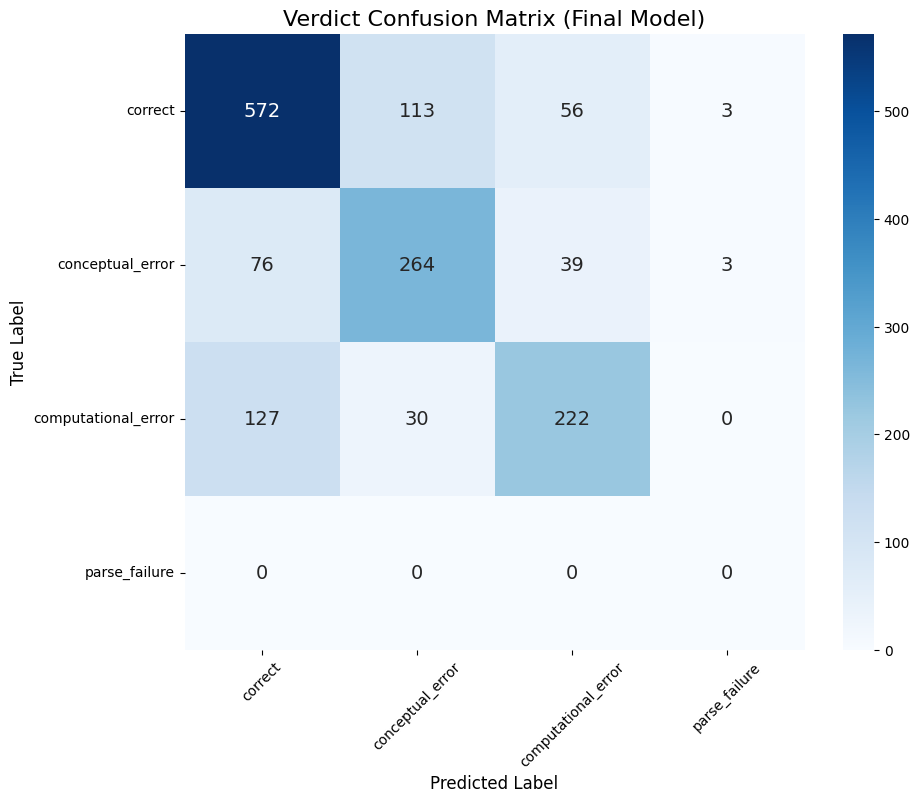

In [18]:
##########
# CONFUSION MATRIX ANALYSIS
##########
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd

print("--- Generating Confusion Matrix for Final Model Verdicts ---")

# Ensure the final results DataFrame is available
if 'final_results_df' not in locals():
    print("Error: `final_results_df` not found. Please run the final evaluation cell first.")
else:
    # Define the order of labels for a consistent matrix layout
    labels = ['correct', 'conceptual_error', 'computational_error', 'parse_failure']

    # Extract the true and predicted values, filling any parse failures
    y_true = final_results_df['expected_verdict']
    y_pred = final_results_df['predicted_verdict'].fillna('parse_failure')

    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    # Create a DataFrame for better labeling with seaborn
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)

    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
                annot_kws={"size": 14}) # Increase annotation font size

    plt.title('Verdict Confusion Matrix (Final Model)', fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

In [ ]:
# ##########
# # PIPELINE STEP 5: PUSH TO HUB
# ##########

# if CONFIG["save_to_hf"]:
#     print("\nPushing the final MERGED model to the Hugging Face Hub...")
#     # The merged model can be pushed directly using its save directory
#     hf_repo_id = CONFIG["experiment_id"]
#     merged_model_dir = str(CONFIG["output_dir"] / "final_merged_model")

#     # Use the API to upload the folder
#     from huggingface_hub import HfApi
#     api = HfApi()
#     api.upload_folder(
#         folder_path=merged_model_dir,
#         repo_id=hf_repo_id,
#         repo_type="model"
#     )
#     print(f"✅ Final merged model pushed to Hub repo: {hf_repo_id}")
# else:
#     print("\nSkipping Hugging Face Hub upload as per configuration.")

In [ ]:
# ##########
# # 2. UNZIP YOUR SAVED RESULTS
# ##########
# import zipfile
# from pathlib import Path

# # IMPORTANT: Replace this with the actual name of your uploaded zip file
# zip_filename = "gene_ter_3N_exp_eln_nl_phi4_20250803_174501_results.zip" #<-- CHANGE THIS

# zip_path = Path("/content/") / zip_filename

# if not zip_path.exists():
#     raise FileNotFoundError(f"'{zip_filename}' not found. Please upload the file first.")

# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall("/content/")

# # The unzipped folder name is the experiment ID
# experiment_id = zip_filename.replace("_results.zip", "")
# experiment_dir = Path("/content/") / experiment_id
# print(f"✅ Successfully unzipped results to: {experiment_dir}")

# ##########
# # 3. LOAD, MERGE, AND PUSH
# ##########
# import torch
# from transformers import AutoModelForCausalLM, AutoTokenizer
# from peft import PeftModel

# # --- Configuration ---
# # We can get these from your unzipped folder name and a config file
# # or define them manually.
# BASE_MODEL_NAME = "microsoft/phi-4-mini-instruct" # Or whatever you used
# ADAPTER_DIR = experiment_dir / "final_best_model" # Or final_adapter
# HF_REPO_ID = experiment_id # Use the experiment ID as the repo name

# # --- Load Base Model and Adapter ---
# print("Loading base model for merging...")
# # Load on the CPU to be memory-efficient
# base_model = AutoModelForCausalLM.from_pretrained(
#     BASE_MODEL_NAME,
#     torch_dtype=torch.float16,
#     low_cpu_mem_usage=True,
#     trust_remote_code=True,
# )

# print(f"Loading adapter from: {ADAPTER_DIR}")
# # Apply the saved LoRA adapter to the base model
# model_with_adapter = PeftModel.from_pretrained(base_model, str(ADAPTER_DIR))

# # --- Merge the Weights ---
# print("Merging adapter weights into the base model...")
# merged_model = model_with_adapter.merge_and_unload()
# print("Merge complete.")

# # --- Load the Tokenizer ---
# # The tokenizer was saved alongside the adapter
# tokenizer = AutoTokenizer.from_pretrained(ADAPTER_DIR)

# # --- Push to Hugging Face Hub ---
# print(f"Pushing final merged model and tokenizer to Hub repo: {HF_REPO_ID}")
# merged_model.push_to_hub(HF_REPO_ID)
# tokenizer.push_to_hub(HF_REPO_ID)

# print(f"\n✅✅✅ Successfully uploaded model to: https://huggingface.co/{HF_REPO_ID}")